In [1]:
from __future__ import unicode_literals

import os

import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import random

from pyecharts import Bar, Boxplot, Pie

import warnings; warnings.filterwarnings(action='ignore')

large = 22; med = 16; small = 12
params = {'axes.titlesize': large,
          'legend.fontsize': med,
          'figure.figsize': (5,3),
          'axes.labelsize': med,
          'axes.titlesize': med,
          'xtick.labelsize': med,
          'ytick.labelsize': med,
          'figure.titlesize': large}
mpl.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams.update(params)
plt.style.use('seaborn-whitegrid')
sns.set_style("white")
%matplotlib inline
# 指定默认字体
mpl.rcParams['font.sans-serif'] = ['Microsoft YaHei'] 
# 解决保存图像是负号'-'显示为方块的问题
mpl.rcParams['axes.unicode_minus'] = False 

ERROR:lml.utils:failed to import pyecharts_snapshot
Traceback (most recent call last):
  File "D:\ProgramData\Anaconda3\lib\site-packages\lml\utils.py", line 43, in do_import
    plugin_module = __import__(plugin_module_name)
ModuleNotFoundError: No module named 'pyecharts_snapshot'


## 单一变量的可视化

数据分布大体情况就是直方图
数据的中位数 平均值就是箱线图


In [2]:
class UnivariateEDA(object):
    """
    对于dataframe数据中单一字段的数据可视化。
    对于类别型（category）数据，建议使用柱形图（），饼图();
    对于数值型（numeric）数据，建议使用直方图（）查看数据分布整体趋势，箱型图（）查看数据的中位数、平均值等。
    """
    
    def __init__(self, data):
        """
        数据初始化，必须传入dataframe文件或者文件的有效路径。
        """
        #数值型类型
        self._numeric_type = ['int', 'int32', 'int64', 'float', 'float32', 'float64']
        
        #归一化函数
        self._log_scaler = lambda x: np.log10(x) / np.log10(max(x))
        self._min_max_scaler = lambda x:(x-np.min(x))/(np.max(x) - np.min(x))
        self._z_score_scaler = lambda x: (x - np.mean(x)) / np.std(x)
        self._no_scale = lambda x: x
        
        if isinstance(data, pd.DataFrame):
            self.data = data
        elif isinstance(data,str) and os.path.exists(fpath):
            self.fpath = data
            self.data = self._read_data()
        else:
            print('请输入dataframe文件')
            return 
        return
    
    def _read_data(self):
        """
        如果传入的是文件路径，自动读取文件。
        """
        self.data = pd.read_csv(self.fpath)
        return self.data
    
    def plot_distplot(self, category=None, hist=True, kde=True, bins=50,
                      minMaxScale=False ,zScoreScale=False, logScale=False,
                     figsize=params['figure.figsize'], dpi=90, ylim=None, color='g'):
        """
        绘制直方图，查看数值型数据的分布。
        
        参数说明：
        category：必须传入的字段名称，必须是数值型。
        hist: 画直方图的柱形
        kde：画高斯核的曲线图
        minMaxScale:对数据进行min-max归一化
        zScoreScale: 对数据进行z-score归一化
        logScale:对数据进行log归一化
        bins:直方图中柱形的数量。
        figsize：（x,y）代表图显示的x和y坐标。
        dpi: 图形的不透明度。
        ylim: y轴的坐标限制。
        color: 绘制颜色。
        """
        
        if category == None:
            print('请输入数值型字段名称')
            return
        if self.data[category].dtype not in self._numeric_type:
            print('字段格式错误，请传入数值型字段绘制直方图')
            return
        
        plt.figure(figsize=figsize, dpi=dpi)
        if minMaxScale: 
            scaler = self._min_max_scaler
            scaler.name = 'minMaxScale'
        elif zScoreScale: 
            scaler = self._z_score_scaler
            scaler.name = 'zScoreScale'
        elif logScale:
            scaler = self._log_scaler
            scaler.name = 'logScale'
        else:
            scaler = self._no_scale
            scaler.name = 'noScale'
        if pd.isnull(self.data[category]).sum() > 0:
             self.data = self.data[pd.notnull(self.data[category])]
        if self.data[category].dtype in self._numeric_type:
            displot_ = sns.distplot(self.data[[category]].apply(scaler),
                         color=color, hist=hist, kde=kde,
                         hist_kws={'alpha':0.5})

        plt.xticks(rotation=90)
        plt.gca().set(title=category +'_with_'+ scaler.name+ '    Distplot', ylim=ylim )
        plt.show()
        
        
    def plot_pie_with_explode(self, category, n=None, ascending=False,
                              figsize=params['figure.figsize'], dpi=90,
                              useEcharts=True, radius=[0,50], rosetype=None):
        """
        绘制饼图，查看类别型数据中每个类别的占比。
        
        参数说明：
        category：必须传入的字段名称，建议是类别型。
        n:饼图中突出块的数量，
        ascending：按照百分比从大到小排列
        figsize：（x,y）代表图显示的x和y坐标。
        dpi: 图形的不透明度。
        useEcharts: 是否使用echarts
        radius: list [内半径，外半径]
        rosetype:'area','radius'可选，通过半径区分数据大小
        """
        
        if category == None:
            print('请输入数值型字段名称')
            return
        
        fig, ax = plt.subplots(figsize=figsize, subplot_kw=dict(aspect="equal"), dpi=dpi)
        df = self.data.groupby(category).size().reset_index(name='counts')
        df = df.sort_values('counts',ascending=ascending)
        data_counts= df['counts']
        categories = df[category]
        size = df[category].value_counts().index.size
        explode = [0]*size
        if n != None:
            explode[n-1] = 0.1

        # 计算显示的百分比
        def func(pct, allvals):
            absolute = int(pct/100.*np.sum(allvals))
            return "{:.1f}% ({:d} )".format(pct, absolute)

        wedges, texts, autotexts = ax.pie(data_counts, 
                                          autopct=lambda pct: func(pct, data_counts),
                                          textprops=dict(color="w"), 
                                          colors=plt.cm.Dark2.colors,
                                          startangle=140, 
                                          explode=explode)

        ax.legend(wedges, categories, title=category, 
                  loc="center left", 
                  bbox_to_anchor=(1, 0, 0.5, 1))
        plt.setp(autotexts, size=10, weight=700)
        ax.set_title(category + "    Pie Chart")
        plt.show()
        
        # 使用echarts
        if useEcharts:
            pie= Pie(category, title_pos='center', width=700, height=350)
            pie.add(name=category, attr=df[category], value=df['counts'],
                    radius=radius, rosetype=rosetype, is_label_show=True,
                    legend_pos='right', legend_orient='vertical')
            pie.render()
            return pie
        
    def plot_bar(self, category, figsize=params['figure.figsize'], dpi=90, 
                 useEcharts=True, is_stack=True, bar_category_gap='20%',
                 ylim=None, ascending=False,):
        """
        绘制柱形图，查看每个类别的数量。
        
        参数说明：
        category：必须传入的字段名称，建议是类别型。
        figsize：（x,y）代表图显示的x和y坐标。
        useEcharts:是否使用echarts
        dpi: 图形的不透明度。
        ylim:y轴坐标的大小
        ascending：按照百分比从大到小排列
        useEcharts: 是否使用echarts
        is_stack： 同一类别堆叠显示
        bar_category_gap: 0是直方图
        """
        
        if category == None:
            print('请输入数值型字段名称')
            return
        plt.figure(figsize=figsize, dpi=dpi)
        df = self.data.groupby(category).size().reset_index(name='counts')
        df = df.sort_values('counts', ascending=False)
        n = df[category].unique().__len__()+1
        all_colors = list(plt.cm.colors.cnames.keys())
        random.seed(100)
        c = random.choices(all_colors, k = n)
            
        rects = plt.bar(df[category],df['counts'],color=c, width=0.03*n)
        for rect in rects:
            height = rect.get_height()
            plt.text(rect.get_x()+rect.get_width()/2., 
                     1.03*height, 
                     "%s" % float(height),
                     horizontalalignment='left', 
                     verticalalignment='bottom', 
                     fontdict={'fontweight' : 30, 'size' : 10})

        plt.xticks(df[category],rotation=90)
        plt.tick_params(labelsize=12)
        plt.title(category+"    Bars", fontsize=15)
        plt.ylabel(category, fontsize = 12)
        plt.ylim(0,max(df['counts'])*1.5)
        plt.show()
        
        # 使用echarts
        if useEcharts:
            bar= Bar(category, title_pos='center', width=700, height=350)
            bar.add(category, df[category], df['counts'],
                    is_label_show=True, is_stack=is_stack, bar_category_gap=bar_category_gap,
                    xaxis_name=category, xaxis_name_size=16,
                    yaxis_name='counts', yaxis_name_size=16, yaxis_name_gap=50,
                    legend_pos='right', legend_orient='vertical')
            bar.render()
            return bar
        
    def plot_box(self, category, minMaxScale=False ,zScoreScale=False, logScale=True,
                useEcharts=True, figsize=params['figure.figsize'], ylim=None):
        """
        绘制箱型图，查看每个字段数据分布的中位数、四分位数、均值等。
        
        参数说明：
        category：必须传入的字段名称,必须是数值型
        minMaxScale:对数据进行min-max归一化
        zScoreScale: 对数据进行z-score归一化
        logScale:对数据进行log归一化
        figsize：（x,y）代表图显示的x和y坐标。
        dpi: 图形的不透明度。
        ylim:y轴坐标的大小
        add_n_obs_state：是否显示每一区间的点
        """
        
        if category == None:
            print('请输入数值型字段名称')
            return
        if self.data[category].dtype not in self._numeric_type:
            print('字段格式错误，请传入数值型字段绘制箱型图')
            return
        
        plt.figure(figsize = figsize, dpi=80)
        # 数据归一化
        if minMaxScale: 
            scaler = self._min_max_scaler
            scaler.name = 'minMaxScale'
        elif zScoreScale: 
            scaler = self._z_score_scaler
            scaler.name = 'zScoreScale'
        elif logScale:
            scaler = self._log_scaler
            scaler.name = 'logScale'
        else:
            scaler = self._no_scale
            scaler.name = 'noScale'
        if pd.isnull(self.data[category]).sum() > 0:
            self.data = self.data[pd.notnull(self.data[category])]
        if self.data[category].dtype in self._numeric_type:
            sns.boxplot(x = category, data=self.data[[category]].apply(scaler), notch=True)
            sns.stripplot(x = category, data=self.data[[category]].apply(scaler), 
                          color='black', size=3, jitter=1)
            if useEcharts:
                boxplot = Boxplot(title=category, title_pos='center', width=700, height=350)
                x_axis = [category]
                y_axis = [self.data[[category]].apply(scaler)[category].tolist()]
                # 转换数据
                _yaxis = boxplot.prepare_data(y_axis)      
                boxplot.add(category, x_axis, _yaxis, is_label_show=True,
                            legend_pos='right', legend_orient='vertical')
                boxplot.render()
                
        plt.xticks(rotation = 60)
        plt.gca().set(title = category + '_with_'+ scaler.name+ '    Box', ylim=ylim)
        plt.show()
        if useEcharts:
            return boxplot



In [3]:
fpath = './data/train.csv'
plotUni = UnivariateEDA(fpath)

### 柱形图

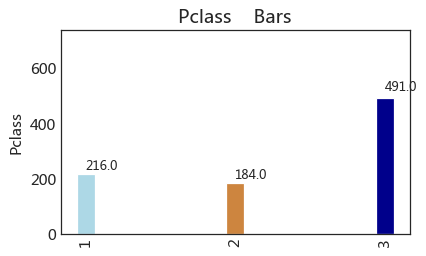

In [4]:
# fpath = './data/data2.csv'
# plotUni = UnivariateEDA(fpath)
# categories = [ 'Is_Demand','B_POI_Category', 'intention_subject_label', 'B_POI_Rank']
# for cate in  categories:
#     plotUni.plot_bar( cate)
plotUni.plot_bar('Pclass')

### 直方图 


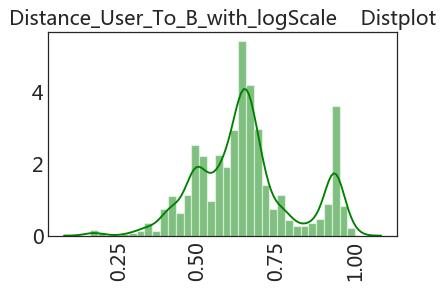

In [15]:
fpath = './data/data2.csv'
plotUni = UnivariateEDA(fpath)
plotUni.plot_distplot('Distance_User_To_B',logScale=True)


### 饼图

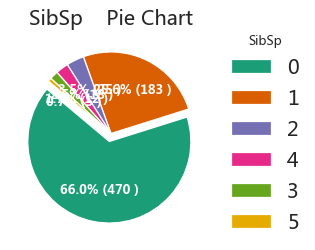

In [6]:
# plotUni.plot_pie_with_explode('B_POI_Category',1,figsize = (12,10))
# plotUni.plot_pie_with_explode('intention_subject_label',1)
# plotUni.plot_pie_with_explode('Is_Demand')
plotUni.plot_pie_with_explode('SibSp', 1)

### 箱型图

In [7]:
fpath = './data/train.csv'
plotUni = UnivariateEDA(fpath)

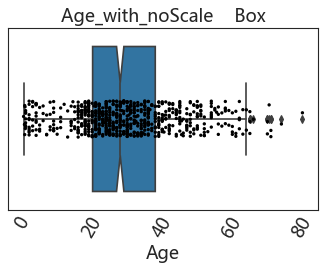

In [8]:
plotUni.plot_box(category='Age', logScale=False)


In [9]:
# plotUni.plot_box(category='Distance_User_To_B', logScale=True)